# Workshop Preparations
2024-10-21 daniel.flemstrom@ri.se , nuria.agues.paszkowsky@ri.se


# Skicka en geometri och få tillbaka saker:
- en tidsserie med medelvärden **(över en geometri?)**, 
- en bild att titta på **(TCI (RGB image))**,
- alla banddata, **(Blir lite knepigt, måste läsa en kub per upplösning)**
- ndvi-värden **(använd ndvi processen från tutorial)**
- molnmaskerad bild, **(SCL maskerad, hitta tutorial)***
- skugg%,  **( SCL, vilken flagga )**
- moln%,  **(SCL samma flagga som molnmask)**

Dema vår quality index på nåt sätt ??? 

In [7]:
# from Notebook RGB


In [2]:
import openeo
from config import user,passwd,eo_service_url
import io
import rasterio.plot
import numpy as np
from demo_regions import s2
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:

connection = openeo.connect(eo_service_url) 
connection.authenticate_basic(username=user, password=passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [6]:
res = connection.load_collection(
    collection_id=s2.s2_msi_l2a,
    spatial_extent=s2.bbox.karlstad_mini_land,
    temporal_extent=s2.timespans.one_image,
    bands=['b04', 'b03', 'b02', 'b08'],
)

In [8]:
# Download the cube as gtiff image data
s2_image_data2 = res.download(format="gtiff")

In [9]:
# Open the image data using rasterio
filelike = io.BytesIO(s2_image_data2)
im = rasterio.open(filelike)

In [10]:
# 1. Read the bands as arrays
r = im.read(1)  # Band 4 (Red)
g = im.read(2)  # Band 3 (Green)
b = im.read(3)  # Band 2 (Blue)
nir = im.read(4) # Band 8 (NIR)
print(r)
print(g)
print(b)
print(nir)

[[238. 254. 312. ... 465. 410. 438.]
 [273. 330. 332. ... 493. 367. 333.]
 [321. 383. 313. ... 298. 230. 279.]
 ...
 [214. 228. 245. ... 233. 158. 217.]
 [277. 290. 269. ... 238. 193. 195.]
 [244. 247. 262. ... 187. 180. 184.]]
[[433. 401. 518. ... 656. 606. 605.]
 [485. 462. 520. ... 697. 563. 501.]
 [477. 587. 597. ... 417. 345. 335.]
 ...
 [325. 322. 331. ... 291. 290. 314.]
 [328. 353. 363. ... 283. 266. 293.]
 [313. 328. 363. ... 327. 331. 319.]]
[[472. 479. 515. ... 572. 573. 560.]
 [510. 433. 492. ... 590. 539. 554.]
 [561. 593. 558. ... 502. 462. 501.]
 ...
 [493. 438. 521. ... 462. 440. 462.]
 [508. 503. 509. ... 427. 412. 445.]
 [512. 496. 526. ... 477. 437. 490.]]
[[1860. 1696. 1994. ... 3212. 3038. 2644.]
 [1888. 1950. 2386. ... 3176. 2288. 2108.]
 [1968. 2304. 2382. ... 1456.  727.  925.]
 ...
 [ 104.  117.  197. ...  106.   74.   77.]
 [ 137.  136.  201. ...   97.   68.   84.]
 [ 156.  163.  197. ...  101.   88.   81.]]


In [11]:
# 2. Normalize the data to the range 0-255 for display
def normalize(array):
    array_min, array_max = np.percentile(array, (1, 99))  # Clip values between 1st and 99th percentile
    array = np.clip(array, array_min, array_max)  # Clip the extreme values
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)


In [12]:
r_normalized = normalize(r)
g_normalized = normalize(g)
b_normalized = normalize(b)
nir_normalized = normalize(nir)

print(r_normalized)
print(g_normalized)
print(b_normalized)
print(nir_normalized)

[[10 12 20 ... 40 33 36]
 [15 22 23 ... 43 27 23]
 [21 29 20 ... 18  9 16]
 ...
 [ 7  9 11 ... 10  0  8]
 [15 17 14 ... 10  5  5]
 [11 12 13 ...  4  3  3]]
[[28 23 41 ... 62 54 54]
 [36 33 41 ... 68 48 38]
 [35 51 53 ... 26 15 13]
 ...
 [12 11 13 ...  7  6 10]
 [12 16 18 ...  5  3  7]
 [10 12 18 ... 12 13 11]]
[[15 17 22 ... 32 32 30]
 [22  9 19 ... 35 26 29]
 [30 35 29 ... 20 14 20]
 ...
 [19 10 23 ... 14 10 14]
 [21 20 21 ...  8  6 11]
 [22 19 24 ... 16 10 18]]
[[126 115 135 ... 220 208 181]
 [128 132 163 ... 218 156 143]
 [134 157 162 ...  98  47  61]
 ...
 [  4   5  10 ...   4   2   2]
 [  6   6  11 ...   3   1   3]
 [  8   8  10 ...   4   3   2]]


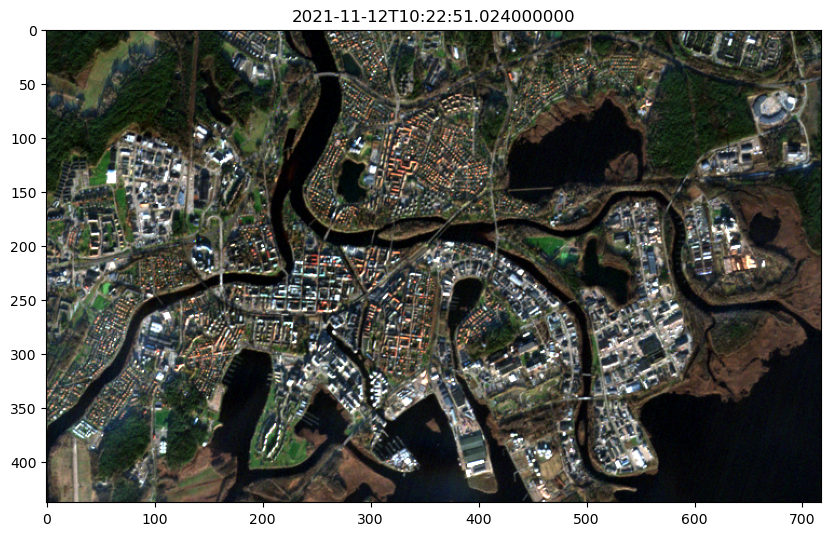

In [13]:
# 3. Stack the bands into an RGB image
rgb = np.dstack((r_normalized, g_normalized, b_normalized))

# 4. Display the RGB image using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb)
ax.set_title(im.tags()["timestamp"])
plt.show()

In [23]:
# NDVI from Processes

In [16]:
import openeo
from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
# a. connect to the openeo back-end
conn = openeo.connect(eo_service_url)
conn.authenticate_basic(username= user, password=passwd)




<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

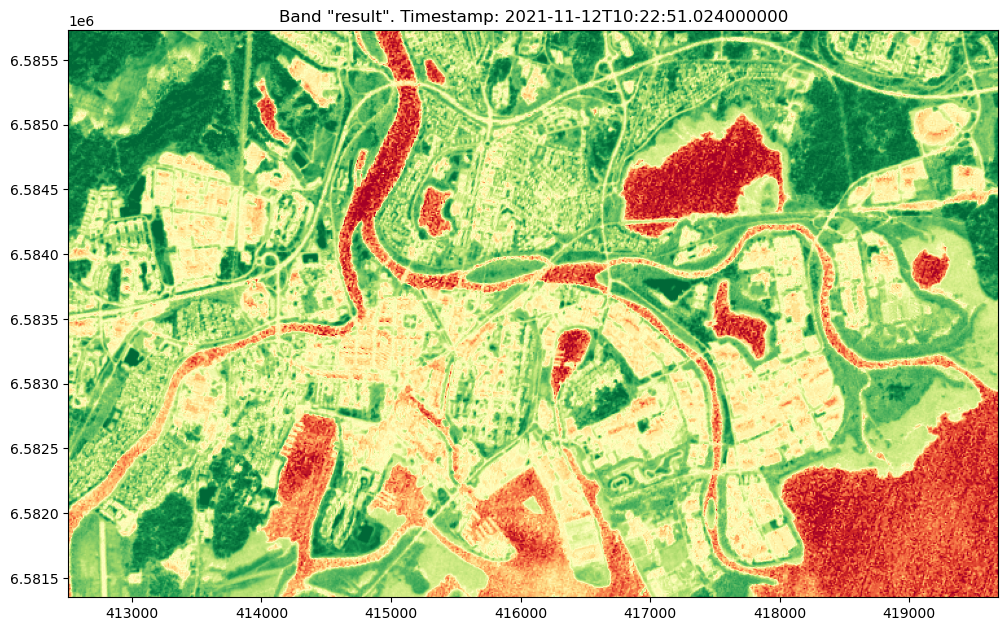

In [17]:
# B. Loading the data
cube=conn.load_collection(s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.one_image,
                         bands=['b04','b08'])
# C.Building and Executing the NDVI Process
res =cube.ndvi(nir="b08",red="b04").download(format="gtiff")
# D. Visulizing the result
_ = show_result(res,is_ndvi=True)

In [20]:
# SCL masking from Polygons_Areas

In [22]:
import openeo 
from config import user,passwd,eo_service_url

# Connect to OpenEO
conn = openeo.connect(eo_service_url)

conn.authenticate_basic(username=user, password=passwd)

# 1. Load the data
datacube = conn.load_collection(
    collection_id = "s2_msi_l2a",
    bands=["scl"], # We may add more bands here give that they have the same resolution
    spatial_extent=s2.bbox.karlstad_mini_land,
    temporal_extent=["2023-06-12", "2023-06-13"]
)
# 2. Mask out valid pixels
masked_datacube = datacube.mask(datacube.band("scl") != 4) # 4 represents 'vegetation'
masked_datacube =  masked_datacube == 4 
# 3. Calculate area using pixel count
pixel_area = 20 * 20  # For 10m x 10m resolution
valid_pixel_count = masked_datacube.aggregate_spatial(s2.bbox.karlstad_mini_land, "sum").execute()
total_area = valid_pixel_count['data'][0][0][0] * pixel_area
total_area

OpenEoClientException: Invalid geometry type None, must be one of ['Point', 'MultiPoint', 'LineString', 'MultiLineString', 'Polygon', 'MultiPolygon', 'GeometryCollection', 'Feature', 'FeatureCollection']

# Antal pixlar med vegetation (Daniel)

# Bild med moln, bild utan moln
# Tänkt att använda filter_quality, filter fine_quality (Daniel makes a figure)

# data från andra myndigheter
(ta deras SKS Cloud index grejorna som vi pillrat med för qindex)

- Interpolera direkt i bilderna, applicera ”curnals” (beräkningsrutor)
kernels????, menas indexrutorna ??? (Skrivit till Viktoria)


# Applicera något känt som tex är gjort på höjdmodellen, på något annat
- läsa in höjdmodell (kan vi ju inte göra, den måste göras produkt, stac_item.json och indexeras)

